In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

## Kraichnan-Orszag Three-Mode Problem

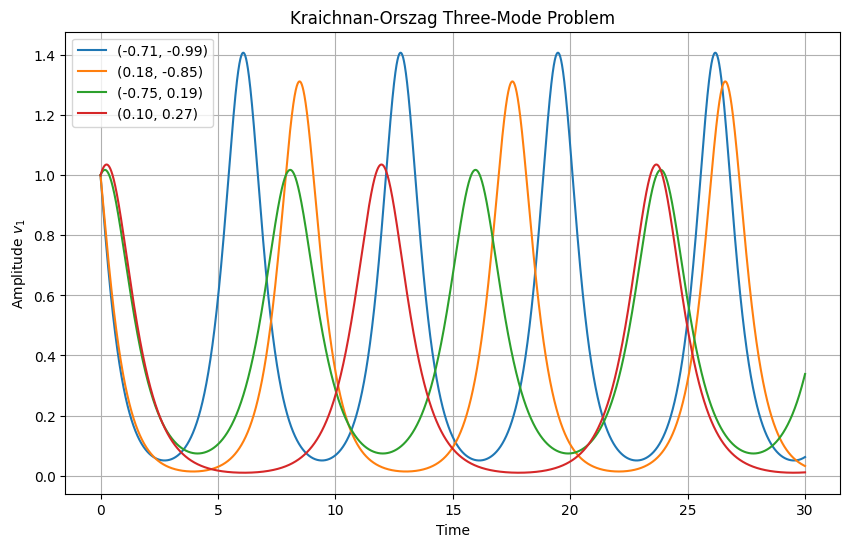

In [36]:
initial_settings = [
    [-0.71, -0.99], 
    [0.18, -0.85],
    [-0.75, 0.19],
    [0.10, 0.27]]


t = np.linspace(0, 30, 10000)

plt.figure(figsize=(10, 6))

dataset = []

for i, v0 in enumerate(initial_settings, start=1):

    v0 = [1.0, 0.1*v0[0], 1.0*v0[1]]
    v = odeint(system, v0, t)

    dataset.append(v[:, 0])
    plt.plot(t, v[:, 0], label=f"({10*v0[1]:.2f}, {v0[2]:.2f})")
    
dataset = np.array(dataset)


plt.xlabel('Time')
plt.ylabel('Amplitude $v_1$')
plt.title('Kraichnan-Orszag Three-Mode Problem')
plt.legend()
plt.grid(True)
plt.show()

## Parameter Sampling

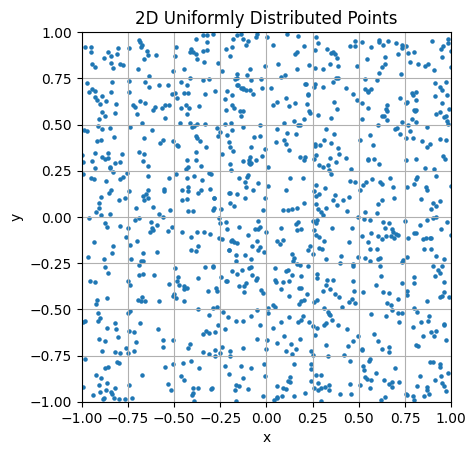

In [37]:
num_samples = 1024


x_points = np.empty(num_samples)
y_points = np.empty(num_samples)


for i in range(num_samples):
    x, y = sample_point()
    x_points[i] = x
    y_points[i] = y


plt.scatter(x_points, y_points, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Uniformly Distributed Points')
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [38]:
initial_settings = np.vstack((x_points, y_points)).T

In [39]:
dataset = generate_solutions(initial_settings)

print('dataset dims:', dataset.shape)

dataset dims: (1024, 10000)


## Dimension Reduction

In [7]:
n_components = 50
n_clusters = 5

In [8]:
pca = PCA(n_components=n_components)
PCA_reduced_data = pca.fit_transform(dataset)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
PCA_labels = kmeans.fit_predict(PCA_reduced_data)

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


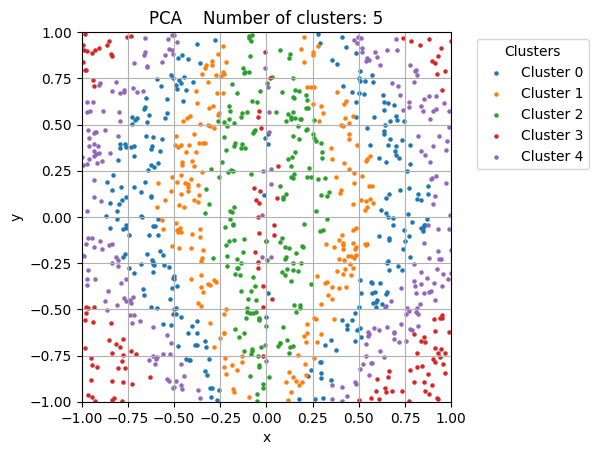

In [9]:
for label in np.unique(PCA_labels):
    mask = PCA_labels == label
    plt.scatter(initial_settings[mask, 0], initial_settings[mask, 1], cmap='viridis', s=5, label=f'Cluster {label}')


plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA    ' + 'Number of clusters: ' + f"{n_clusters}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Single GP

In [10]:
training_iter = 50

In [11]:
train_x = torch.tensor(initial_settings).float()
train_y = torch.tensor(PCA_reduced_data).float()

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_components)
model = MultiOutputGPModel(train_x, train_y, likelihood, n_components)

model.train()
likelihood.train()


optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    if i == training_iter-1:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))


Iter 1/50 - Loss: 6.384
Iter 11/50 - Loss: 3.053
Iter 21/50 - Loss: 2.078
Iter 31/50 - Loss: 1.963
Iter 41/50 - Loss: 1.876


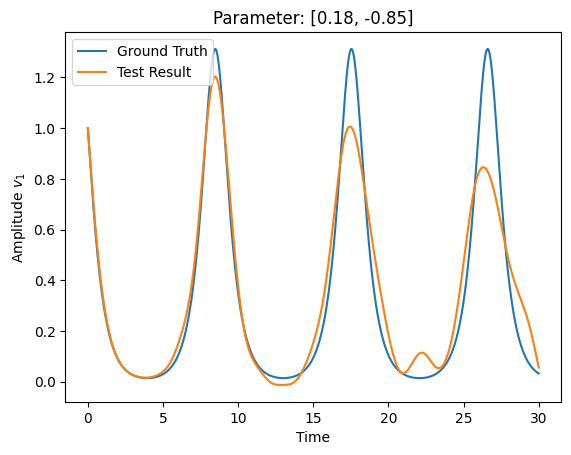

In [12]:
model.eval()
likelihood.eval()

test_param = [0.18, -0.85]

test_x = torch.tensor([
    test_param
]).float()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

reconstructed = pca.inverse_transform(observed_pred.mean)[0]

v0 = [1.0, 0.1*test_param[0], 1.0*test_param[1]]
v = odeint(system, v0, t)

plt.title(f'Parameter: {test_param}')
plt.xlabel('Time')
plt.ylabel('Amplitude $v_1$')
plt.plot(t, v[:, 0], label="Ground Truth")
plt.plot(t, reconstructed, label="Test Result")
plt.legend()
plt.show()

## Multiple GPs

In [48]:
n_clusters_list = [5, 10, 20, 32]
test_param_list = [[0.89,-0.07], [-0.53,0.26], [-0.03,0.81], [0.91,0.02]]

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  0
Iter 1/50 - Loss: 6.648
Iter 11/50 - Loss: 4.059
Iter 21/50 - Loss: 3.115
Iter 31/50 - Loss: 2.751
Iter 41/50 - Loss: 2.603
Iter 50/50 - Loss: 2.528
 
selected_cluster:  3
Iter 1/50 - Loss: 3.176
Iter 11/50 - Loss: 2.324
Iter 21/50 - Loss: 2.035
Iter 31/50 - Loss: 1.891
Iter 41/50 - Loss: 1.779
Iter 50/50 - Loss: 1.663
 
selected_cluster:  0
Iter 1/50 - Loss: 6.649
Iter 11/50 - Loss: 4.059
Iter 21/50 - Loss: 3.114
Iter 31/50 - Loss: 2.748
Iter 41/50 - Loss: 2.604
Iter 50/50 - Loss: 2.529
 
selected_cluster:  1
Iter 1/50 - Loss: 3.593
Iter 11/50 - Loss: 2.555
Iter 21/50 - Loss: 2.208
Iter 31/50 - Loss: 2.046
Iter 41/50 - Loss: 1.951
Iter 50/50 - Loss: 1.875
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  2
Iter 1/50 - Loss: 4.041
Iter 11/50 - Loss: 2.603
Iter 21/50 - Loss: 2.233
Iter 31/50 - Loss: 2.101
Iter 41/50 - Loss: 2.020
Iter 50/50 - Loss: 1.949
 
selected_cluster:  1
Iter 1/50 - Loss: 2.513
Iter 11/50 - Loss: 1.982
Iter 21/50 - Loss: 1.815
Iter 31/50 - Loss: 1.679
Iter 41/50 - Loss: 1.489
Iter 50/50 - Loss: 1.262
 
selected_cluster:  6
Iter 1/50 - Loss: 5.613
Iter 11/50 - Loss: 3.581
Iter 21/50 - Loss: 2.892
Iter 31/50 - Loss: 2.635
Iter 41/50 - Loss: 2.516
Iter 50/50 - Loss: 2.451
 
selected_cluster:  3
Iter 1/50 - Loss: 2.589
Iter 11/50 - Loss: 1.973
Iter 21/50 - Loss: 1.775
Iter 31/50 - Loss: 1.611
Iter 41/50 - Loss: 1.396
Iter 50/50 - Loss: 1.163
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  13
Iter 1/50 - Loss: 4.253
Iter 11/50 - Loss: 2.416
Iter 21/50 - Loss: 2.027
Iter 31/50 - Loss: 1.817
Iter 41/50 - Loss: 1.612
Iter 50/50 - Loss: 1.412
 
selected_cluster:  15
Iter 1/50 - Loss: 2.280
Iter 11/50 - Loss: 1.793
Iter 21/50 - Loss: 1.556
Iter 31/50 - Loss: 1.268
Iter 41/50 - Loss: 0.980
Iter 50/50 - Loss: 0.784
 
selected_cluster:  11
Iter 1/50 - Loss: 4.106
Iter 11/50 - Loss: 2.471
Iter 21/50 - Loss: 2.099
Iter 31/50 - Loss: 1.928
Iter 41/50 - Loss: 1.777
Iter 50/50 - Loss: 1.621
 
selected_cluster:  3
Iter 1/50 - Loss: 2.286
Iter 11/50 - Loss: 1.625
Iter 21/50 - Loss: 1.230
Iter 31/50 - Loss: 0.887
Iter 41/50 - Loss: 0.623
Iter 50/50 - Loss: 0.462
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  20
Iter 1/50 - Loss: 4.077
Iter 11/50 - Loss: 2.243
Iter 21/50 - Loss: 1.711
Iter 31/50 - Loss: 1.327
Iter 41/50 - Loss: 1.003
Iter 50/50 - Loss: 0.794
 
selected_cluster:  24
Iter 1/50 - Loss: 2.297
Iter 11/50 - Loss: 1.674
Iter 21/50 - Loss: 1.305
Iter 31/50 - Loss: 0.965
Iter 41/50 - Loss: 0.705
Iter 50/50 - Loss: 0.534
 
selected_cluster:  12
Iter 1/50 - Loss: 4.128
Iter 11/50 - Loss: 2.447
Iter 21/50 - Loss: 2.069
Iter 31/50 - Loss: 1.880
Iter 41/50 - Loss: 1.705
Iter 50/50 - Loss: 1.533
 
selected_cluster:  2
Iter 1/50 - Loss: 2.213
Iter 11/50 - Loss: 1.572
Iter 21/50 - Loss: 1.164
Iter 31/50 - Loss: 0.822
Iter 41/50 - Loss: 0.556
Iter 50/50 - Loss: 0.398
 


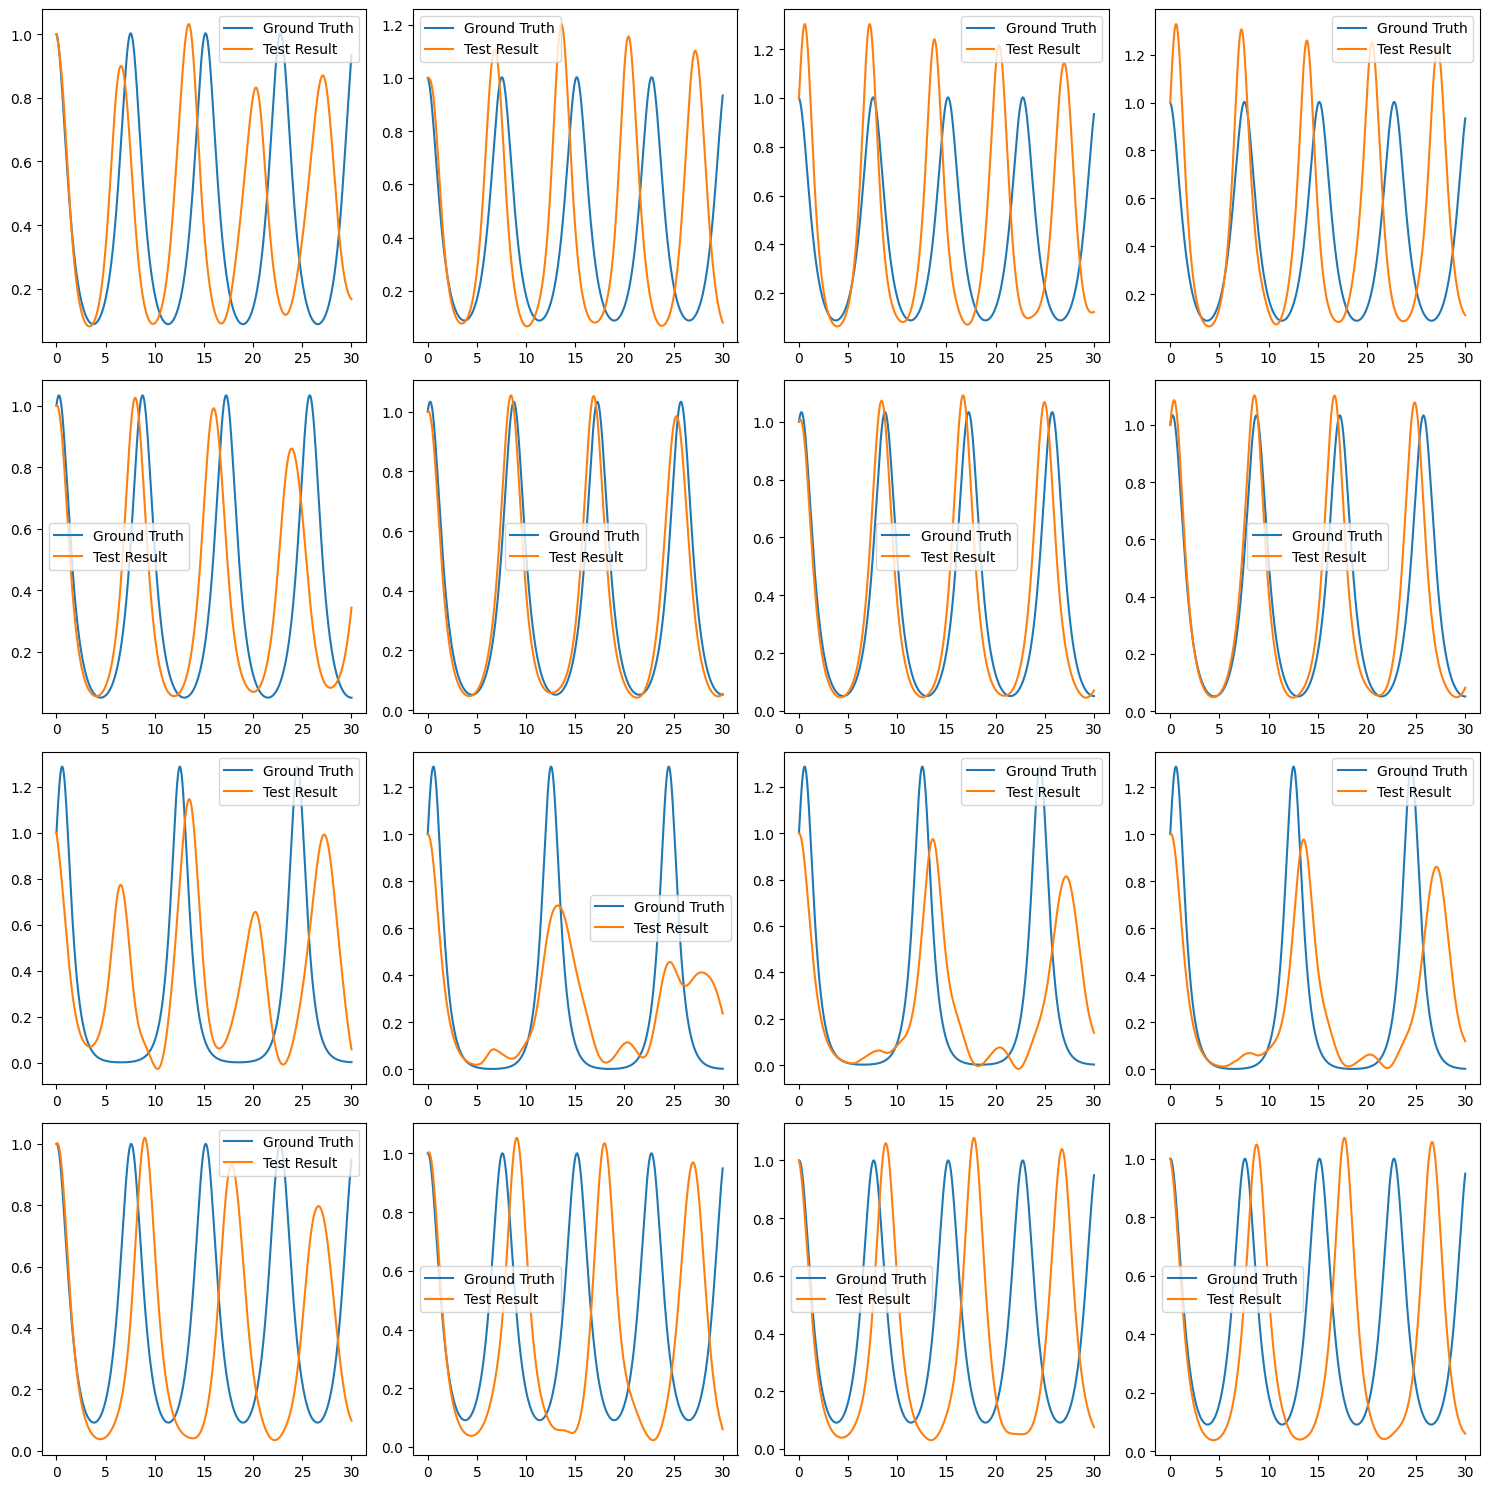

In [49]:
fig, axes = plt.subplots(len(n_clusters_list), len(test_param_list), figsize=(15, 15))

for ax_i, n_clusters in enumerate(n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters)
    PCA_labels = kmeans.fit_predict(PCA_reduced_data)
    
    partitioned_initial_settings = []
    partitioned_PCA_reduced_data = []

    for label in range(n_clusters):
        partition = initial_settings[PCA_labels == label]
        partitioned_initial_settings.append(partition)
        partitioned_PCA_reduced_data.append(PCA_reduced_data[PCA_labels == label])

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(initial_settings, PCA_labels)
    
    for ax_j, test_param in enumerate(test_param_list):
        point = np.array([test_param])
        selected_cluster = knn.predict(point)[0]
        print('selected_cluster: ', selected_cluster)
        
        train_x = torch.tensor(partitioned_initial_settings[selected_cluster]).float()
        train_y = torch.tensor(partitioned_PCA_reduced_data[selected_cluster]).float()

        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_components)
        model = MultiOutputGPModel(train_x, train_y, likelihood, n_components)

        model.train()
        likelihood.train()


        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
            if i == training_iter-1:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
                print(' ')
                
        model.eval()
        likelihood.eval()

        test_x = torch.tensor([
            test_param
        ]).float()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(test_x))


        reconstructed = pca.inverse_transform(observed_pred.mean)[0]

        v0 = [1.0, 0.1*test_param[0], 1.0*test_param[1]]
        v = odeint(system, v0, t)

        ax = axes[ax_j][ax_i]
#         ax.set_title(f'Parameter: {test_param},    number of clusters: {n_clusters}')
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Amplitude $v_1$')
        ax.plot(t, v[:, 0], label="Ground Truth")
        ax.plot(t, reconstructed, label="Test Result")
        ax.legend()

plt.tight_layout()
plt.show()
        

## Multiple GPs: 5 clusters

In [13]:
n_clusters = 5

pca = PCA(n_components=n_components)
PCA_reduced_data = pca.fit_transform(dataset)

kmeans = KMeans(n_clusters=n_clusters)
PCA_labels = kmeans.fit_predict(PCA_reduced_data)

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


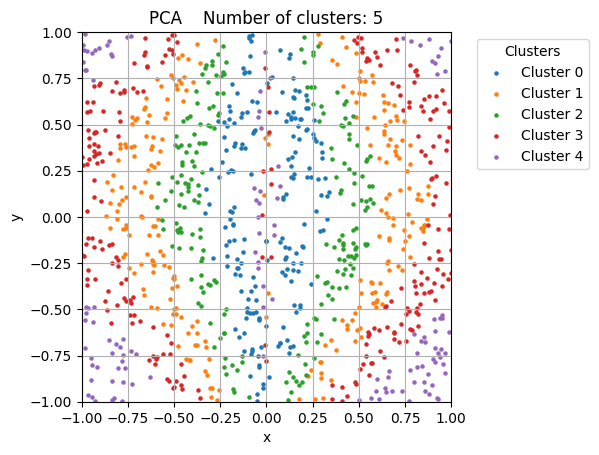

In [14]:
for label in np.unique(PCA_labels):
    mask = PCA_labels == label
    plt.scatter(initial_settings[mask, 0], initial_settings[mask, 1], cmap='viridis', s=5, label=f'Cluster {label}')


plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA    ' + 'Number of clusters: ' + f"{n_clusters}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [15]:
partitioned_initial_settings = []
partitioned_PCA_reduced_data = []

for label in range(n_clusters):
    partition = initial_settings[PCA_labels == label]
    partitioned_initial_settings.append(partition)
    partitioned_PCA_reduced_data.append(PCA_reduced_data[PCA_labels == label])
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(initial_settings, PCA_labels)

KNeighborsClassifier(n_neighbors=3)

In [16]:
test_param = [0.18, -0.85]

point = np.array([test_param])
selected_cluster = knn.predict(point)[0]
print('selected_cluster: ', selected_cluster)

selected_cluster:  2


In [17]:
train_x = torch.tensor(partitioned_initial_settings[selected_cluster]).float()
train_y = torch.tensor(partitioned_PCA_reduced_data[selected_cluster]).float()

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_components)
model = MultiOutputGPModel(train_x, train_y, likelihood, n_components)

model.train()
likelihood.train()


optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    if i == training_iter-1:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/50 - Loss: 3.018
Iter 11/50 - Loss: 2.111
Iter 21/50 - Loss: 1.838
Iter 31/50 - Loss: 1.633
Iter 41/50 - Loss: 1.407


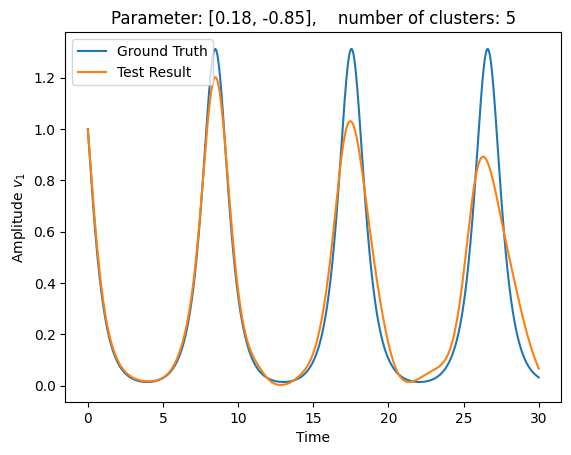

In [18]:
model.eval()
likelihood.eval()

test_x = torch.tensor([
    test_param
]).float()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    

reconstructed = pca.inverse_transform(observed_pred.mean)[0]

v0 = [1.0, 0.1*test_param[0], 1.0*test_param[1]]
v = odeint(system, v0, t)

plt.title(f'Parameter: {test_param},    number of clusters: {n_clusters}')
plt.xlabel('Time')
plt.ylabel('Amplitude $v_1$')
plt.plot(t, v[:, 0], label="Ground Truth")
plt.plot(t, reconstructed, label="Test Result")
plt.legend()
plt.show()

## Multiple GPs: 20 clusters

In [19]:
n_clusters = 20

pca = PCA(n_components=n_components)
PCA_reduced_data = pca.fit_transform(dataset)

kmeans = KMeans(n_clusters=n_clusters)
PCA_labels = kmeans.fit_predict(PCA_reduced_data)

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


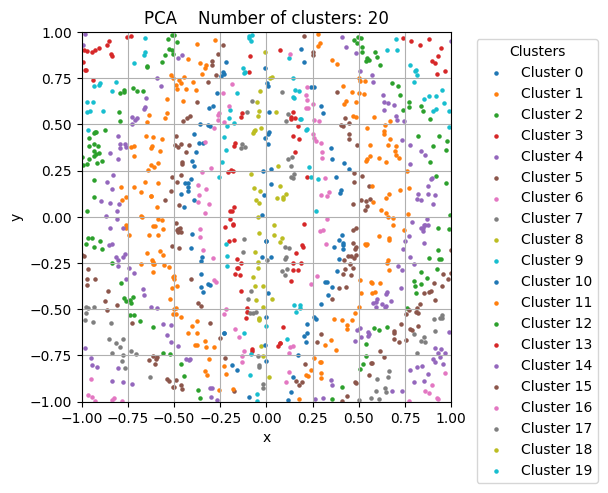

In [20]:
for label in np.unique(PCA_labels):
    mask = PCA_labels == label
    plt.scatter(initial_settings[mask, 0], initial_settings[mask, 1], cmap='viridis', s=5, label=f'Cluster {label}')


plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA    ' + 'Number of clusters: ' + f"{n_clusters}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [21]:
partitioned_initial_settings = []
partitioned_PCA_reduced_data = []

for label in range(n_clusters):
    partition = initial_settings[PCA_labels == label]
    partitioned_initial_settings.append(partition)
    partitioned_PCA_reduced_data.append(PCA_reduced_data[PCA_labels == label])
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(initial_settings, PCA_labels)

KNeighborsClassifier(n_neighbors=3)

In [22]:
point = np.array([test_param])
selected_cluster = knn.predict(point)[0]
print('selected_cluster: ', selected_cluster)

selected_cluster:  0


In [23]:
train_x = torch.tensor(partitioned_initial_settings[selected_cluster]).float()
train_y = torch.tensor(partitioned_PCA_reduced_data[selected_cluster]).float()

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_components)
model = MultiOutputGPModel(train_x, train_y, likelihood, n_components)

model.train()
likelihood.train()


optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    if i == training_iter-1:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/50 - Loss: 1.972
Iter 11/50 - Loss: 1.450
Iter 21/50 - Loss: 1.037
Iter 31/50 - Loss: 0.687
Iter 41/50 - Loss: 0.416


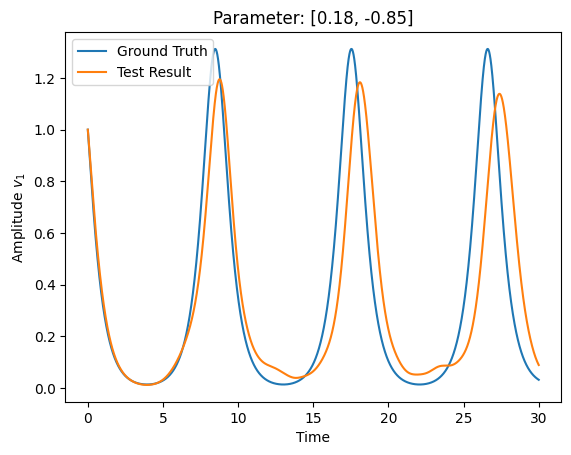

In [24]:
model.eval()
likelihood.eval()

test_x = torch.tensor([
    test_param
]).float()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    

reconstructed = pca.inverse_transform(observed_pred.mean)[0]

v0 = [1.0, 0.1*test_param[0], 1.0*test_param[1]]
v = odeint(system, v0, t)

plt.title(f'Parameter: {test_param}')
plt.xlabel('Time')
plt.ylabel('Amplitude $v_1$')
plt.plot(t, v[:, 0], label="Ground Truth")
plt.plot(t, reconstructed, label="Test Result")
plt.legend()
plt.show()